In [1]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': '****',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': '****'
}

configuration_name = 'os_8cbf59ff782d4a5db7683b1dceef1190_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df=spark.read.parquet(cos.url('First_Time_Buyer_Cleaned.parquet', 'advanceddatasciencecapstone-donotdelete-pr-****'))

# Feature creation

## New features

In [2]:
# create age-group

# drop 'age_group' if already exists
df=df.drop('age_group')


df.createOrReplaceTempView('dftable')
df=spark.sql("""
SELECT *,
CASE WHEN age_buy_property >= 20 AND age_buy_property <  25 THEN '20-24'
    WHEN age_buy_property >= 25 AND age_buy_property <  30 THEN '25-29'
    WHEN age_buy_property >= 30 AND age_buy_property <  35 THEN '30-34'
    WHEN age_buy_property >= 35 AND age_buy_property <  40 THEN '35-39'
    WHEN age_buy_property >= 40 AND age_buy_property <  45 THEN '40-44'
    WHEN age_buy_property >= 45 AND age_buy_property <  50 THEN '45-49'
    WHEN age_buy_property >= 50 AND age_buy_property <  55 THEN '50-54'
    WHEN age_buy_property >= 55 AND age_buy_property <  60 THEN '55-59'
    WHEN age_buy_property >= 60 AND age_buy_property <  65 THEN '60-64'
    WHEN age_buy_property >= 65 AND age_buy_property <= 80 THEN '65-80'
    ELSE 'Unknown'
END AS age_group
FROM dftable    
""")

# df.select('age_buy_property','age_group').show(100)

## One hot encoding

In [3]:
# As shown before, there are few columns contain string (categorical variables), 
# so should be converted to numerical values (one hot encoding):

categorical_columns=[]

for col,col_type in df.dtypes:
    if col_type == 'string':
        categorical_columns.append(col)

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Normalizer

# The index of string vlaues multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

# The encode of indexed vlaues multiple columns
encoders = [OneHotEncoder(dropLast=True,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]


## Transformation Pipeline

In [5]:
# Vectorizing encoded values
numerical_columns=['age_buy_property',
 'income_code',
 'months_income',
 'riskscore',
 'has_email_addr',
 'has_mobile_phone',
 'has_home_phone',
 'has_work_phone',
 'contactability_score',
 'credit_application_last_5yrs',
 'lsm',
 'months_mobile_phone',
 'months_home_phone',
 'months_work_phone',
 'years_occupation'
]

assembler = VectorAssembler(inputCols=numerical_columns+[encoder.getOutputCol() for encoder in encoders],outputCol="features")

# Noticed that normalization degraded the model performance in this problem, so ignored it.
#normalizer = Normalizer(inputCol='features_unnorm', outputCol='features', p=1.0)

# transformation pipeline
pipeline = Pipeline(stages=indexers + encoders+[assembler])

# fit the transformation model
pipelineModel = pipeline.fit(df)

### Initial transformed data

In [6]:
# transform the data
df_transformed=pipelineModel.transform(df)

# Model Definition

### 1. Logistic Regression

In [7]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="buyer",
                        featuresCol="features",
                        maxIter=10,
                        regParam=0.3)    # from 0.3 to 0.1, improve accuracy by around 0.01 (1%)

### 2. XGBoost

In [8]:
from pyspark.ml.classification import GBTClassifier

xgb = GBTClassifier(featuresCol='features', labelCol='buyer')

### 3. Neural Network (Keras)

#### 3.1 Define the network architecture

In [10]:
try:
    import tensorflow
except:
    !pip install tensorflow==1.12.0

In [11]:
try:
    import keras
except:
    !pip install Keras==2.2.4

Using TensorFlow backend.


In [12]:
# install Elephas library (Distributed Deep Learning with Keras & Spark). I couldn't run SystemML.

try:
    import elephas
except:
    !pip install elephas

In [13]:
from keras.models import Sequential
from keras.layers import Dropout,Dense
from keras.models import Model


# number of classes
nb_classes = df_transformed.select('buyer').distinct().count()

# Input dimensions
input_dim = len(df_transformed.select('features').first()[0])


# define the keras model
keras_model = Sequential()

#First Hidden Layer
keras_model.add(Dense(64, activation='relu', input_shape=(input_dim,)))

# dropout (to avoid overfitting)
keras_model.add(Dropout(0.2))

#Second  Hidden Layer
keras_model.add(Dense(32, activation='relu'))

# dropout (to avoid overfitting)
keras_model.add(Dropout(0.2))

#Output Layer
keras_model.add(Dense(nb_classes, activation='softmax'))

# compile the keras model
keras_model.compile(optimizer ='adam',loss='binary_crossentropy', metrics=['accuracy'])

# print out the network structure
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2944      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 5,090
Trainable params: 5,090
Non-trainable params: 0
_________________________________________________________________


#### 3.2 Run Keras model on Spark

In [14]:
# Elephas for Deep Learning on Spark (SystemML alternative)

from elephas.ml_model import ElephasEstimator
from keras import optimizers

# Set and Serialize Optimizer
optimizer_conf = optimizers.Adam(lr=0.01)
opt_conf = optimizers.serialize(optimizer_conf)

# Initialize SparkML Estimator and Get Settings
nnet = ElephasEstimator()
nnet.setFeaturesCol("features")
nnet.setLabelCol("buyer")
nnet.set_keras_model_config(keras_model.to_yaml())
nnet.set_categorical_labels(True)
nnet.set_nb_classes(nb_classes)
nnet.set_num_workers(1)
nnet.set_epochs(10) 
nnet.set_batch_size(64)
nnet.set_verbosity(2)
nnet.set_validation_split(0.10)
nnet.set_optimizer_config(opt_conf)
nnet.set_mode("synchronous")
nnet.set_loss("binary_crossentropy")
nnet.set_metrics(['acc'])

WARNING


ElephasEstimator_18f909db3f11

# Train-Test Split

In [15]:
def train_test_split_spark(df, train_size=0.8, seed=None):
    """
    Split the given Spark DataFrame into train and test sets.
    
    """
    if train_size>=1:
        raise Exception ("Train size must be less than 1.0 !")
    
    if train_size<=0:
        raise Exception ("Train size must be greater than 0 !")

    splits = df.randomSplit([train_size,1-train_size], seed=seed)
    df_train=splits[0]
    df_test=splits[1]
    
    return df_train, df_test

In [16]:
# split the dataset
df_train, df_test = train_test_split_spark(df_transformed, 0.8, seed=2)

# Model Evaluation

### Confusion Matrix

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import MulticlassMetrics

def plot_confusion_matrix(predictions, y_lables=None, title=''):
    
    # Create tuples of (prediction, label)
    predictionAndLabels=predictions.rdd.map(lambda row: (float(row.prediction),float(row.buyer)))

    # Assign the metrics evaluator
    metrics = MulticlassMetrics(predictionAndLabels)
    
    # calculate confusion matrix
    confmat = metrics.confusionMatrix().toArray()

    # plot a heatmap chart
    ax= plt.subplot()
    sns.heatmap(confmat, annot=True, ax = ax, cmap='Blues',fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix: ' + title); 
    if y_lables is not None:
        ax.xaxis.set_ticklabels(y_lables); ax.yaxis.set_ticklabels(y_lables);

    ax.axhline(y=0, color='k',linewidth=2)
    ax.axhline(y=confmat.shape[1], color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=2)

    ax.axvline(x=confmat.shape[1], color='k',linewidth=2)
    
    plt.show();

### Evaluation Metrics

In [18]:
# All-in-one function to evaluate a model and show the results

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def evaluate_model(model, df_train, df_test, labelCol='buyer'):
    # predict both datasets
    prediction_train = model.transform(df_train);
    prediction_test = model.transform(df_test);
    
    
    # Evaluate accuracy score
    eval_metrics = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='buyer');


    # print evaluation metrics
    print("             Model metrics:              ")
    print("=========================================")
    print("Accuracy : Train = %.4f, Test = %.4f" % (eval_metrics.setMetricName('accuracy').evaluate(prediction_train),
                                                    eval_metrics.setMetricName('accuracy').evaluate(prediction_test)))
    print("Precision: Train = %.4f, Test = %.4f" % (eval_metrics.setMetricName('weightedPrecision').evaluate(prediction_train),
                                                    eval_metrics.setMetricName('weightedPrecision').evaluate(prediction_test)))
    print("Recall   : Train = %.4f, Test = %.4f" % (eval_metrics.setMetricName('weightedRecall').evaluate(prediction_train),
                                                    eval_metrics.setMetricName('weightedRecall').evaluate(prediction_test)))
    print("F1 Score:  Train = %.4f, Test = %.4f" % (eval_metrics.setMetricName('f1').evaluate(prediction_train),
                                                    eval_metrics.setMetricName('f1').evaluate(prediction_test)))
    
    # skip this part for elephas deep learning model (elephas does not create 'rawPrediction' column)
    if 'elephas' not in str(type(model)):
        
        # Evaluate AUC score
        eval_auc = BinaryClassificationEvaluator(metricName='areaUnderROC', labelCol=labelCol,rawPredictionCol='rawPrediction')
    
        print("AUC     :  Train = %.4f, Test = %.4f" % (eval_auc.evaluate(prediction_train),
                                                        eval_auc.evaluate(prediction_test)))
    
    # plot confusion matrix
    plot_confusion_matrix(prediction_train,title='Train')
    plot_confusion_matrix(prediction_test,title='Test')
    
    # skip this part for elephas deep learning model
    if 'elephas' not in str(type(model)):
        
        # plot ROC curve
        plt.figure(figsize=(5,5))
        plt.plot([0, 1], [0, 1], 'r--')
        plt.plot(model_lr.summary.roc.select('FPR').collect(),
                 model_lr.summary.roc.select('TPR').collect())
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curve')
        plt.show();
    

In [ ]:
# All-in-one function to evaluate a model and show the results

from pyspark.ml.evaluation import BinaryClassificationEvaluator

def evaluate_model2(model, df_train, df_test):
    # predict both datasets
    prediction_train = model.transform(df_train)
    prediction_test = model.transform(df_test)
    
    # evaluate metrics
    metrics_train = eval_metrics(prediction_train)
    metrics_test = eval_metrics(prediction_test)
    
    # Evaluate AUC score
    eval_auc = BinaryClassificationEvaluator(metricName='areaUnderROC', labelCol='buyer',rawPredictionCol='prediction')


    # print evaluation metrics
    print("           Model metrics:            ")
    print("=====================================")
    print("Accuracy : Train = %.6f, Test = %.6f" % (metrics_train.accuracy, metrics_test.accuracy))
    print("Precision: Train = %.6f, Test = %.6f" % (metrics_train.weightedPrecision(), metrics_test.weightedPrecision()))  # or  average(precision(label=0),precision(label=1))
    print("Recall   : Train = %.6f, Test = %.6f" % (metrics_train.weightedRecall(), metrics_test.weightedRecall()))
    print("F1 Score:  Train = %.6f, Test = %.6f" % (metrics_train.weightedFMeasure(), metrics_test.weightedFMeasure()))
    print("AUC     :  Train = %.6f, Test = %.6f" % (eval_auc.evaluate(prediction_train), eval_auc.evaluate(prediction_test)))
    
    # plot confusion matrix
    plot_confusion_matrix(prediction_train,title='Train')
    plot_confusion_matrix(prediction_test,title='Test')
    
    
    # plot ROC curve
    plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(model_lr.summary.roc.select('FPR').collect(),
             model_lr.summary.roc.select('TPR').collect())
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show();
     


### Step 1 - Training & Evaluation results

#### Logistic Regression

             Model metrics:              
Accuracy : Train = 0.8895, Test = 0.8847
Precision: Train = 0.8898, Test = 0.8851
Recall   : Train = 0.8895, Test = 0.8847
F1 Score:  Train = 0.8896, Test = 0.8848
AUC     :  Train = 0.9529, Test = 0.9500


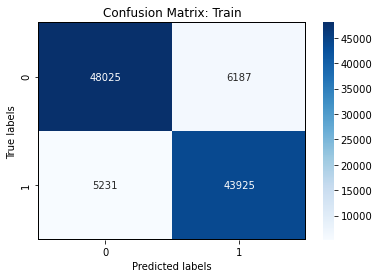

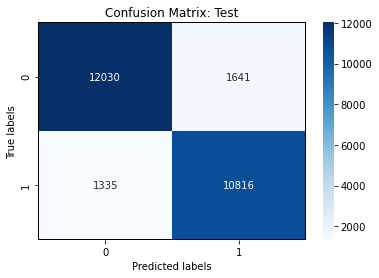

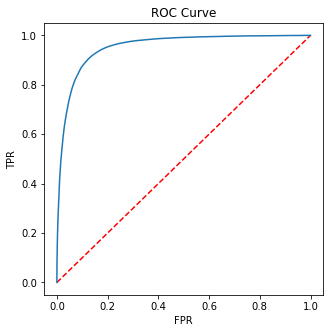

In [19]:
# train the model
model_lr=lr.fit(df_train)

# evaluate the model
evaluate_model(model_lr, df_train, df_test)

#### XGBoost

             Model metrics:              
Accuracy : Train = 0.9031, Test = 0.8975
Precision: Train = 0.9033, Test = 0.8978
Recall   : Train = 0.9031, Test = 0.8975
F1 Score:  Train = 0.9031, Test = 0.8976
AUC     :  Train = 0.9654, Test = 0.9612


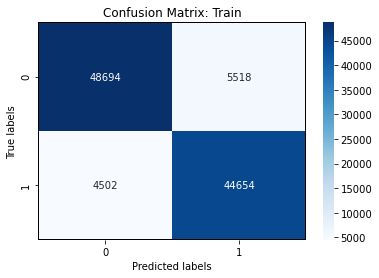

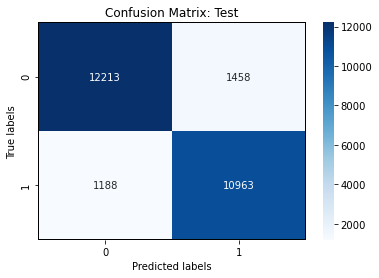

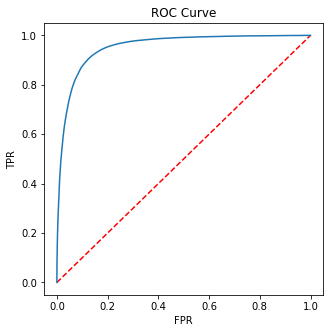

In [20]:
# train the model
model_xgb=xgb.fit(df_train)

# evaluate the model
evaluate_model(model_xgb, df_train, df_test)

#### Keras Neural Network

c:\Miniconda3\envs\kg\lib\site-packages\keras\engine\saving.py:473: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


>>> Fit model
>>> Synchronous training complete.
[[36.  4. 45. ...  0.  0.  0.]
 [36.  6. 45. ...  0.  0.  0.]
 [36.  6. 45. ...  0.  0.  0.]
 ...
 [76.  3. 45. ...  1.  0.  0.]
 [76.  4. 45. ...  1.  0.  0.]
 [77.  2. 45. ...  1.  0.  0.]]
[[36.  5. 45. ...  0.  0.  0.]
 [36.  6. 45. ...  0.  0.  0.]
 [36.  7. 45. ...  0.  0.  0.]
 ...
 [77.  3. 45. ...  1.  0.  0.]
 [77.  5. 45. ...  1.  0.  0.]
 [79.  2. 45. ...  1.  0.  0.]]
             Model metrics:              
Accuracy : Train = 0.8925, Test = 0.8870
Precision: Train = 0.8967, Test = 0.8921
Recall   : Train = 0.8925, Test = 0.8870
F1 Score:  Train = 0.8925, Test = 0.8871


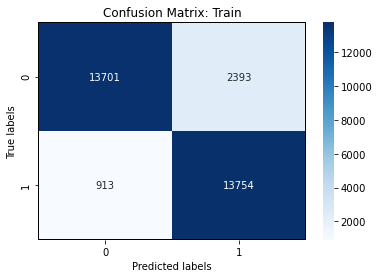

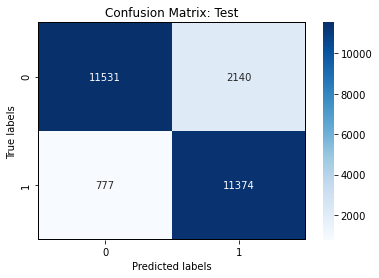

In [21]:
# train the model
model_nn = nnet.fit(df_train)

# evalute the model
# training dataset is too big to be handled by one node; so 30% of it is used for evaluation
evaluate_model(model_nn, df_train.sample(False,0.3), df_test)

## Feature Importance for Logistic Regression

In [22]:
# Get number of transformed features
row1 = df_transformed.select('features').first()['features']

print('Number of features used: ',row1.size)

Number of features used:  45


So 45 features used in the model. Let's see how important they are.

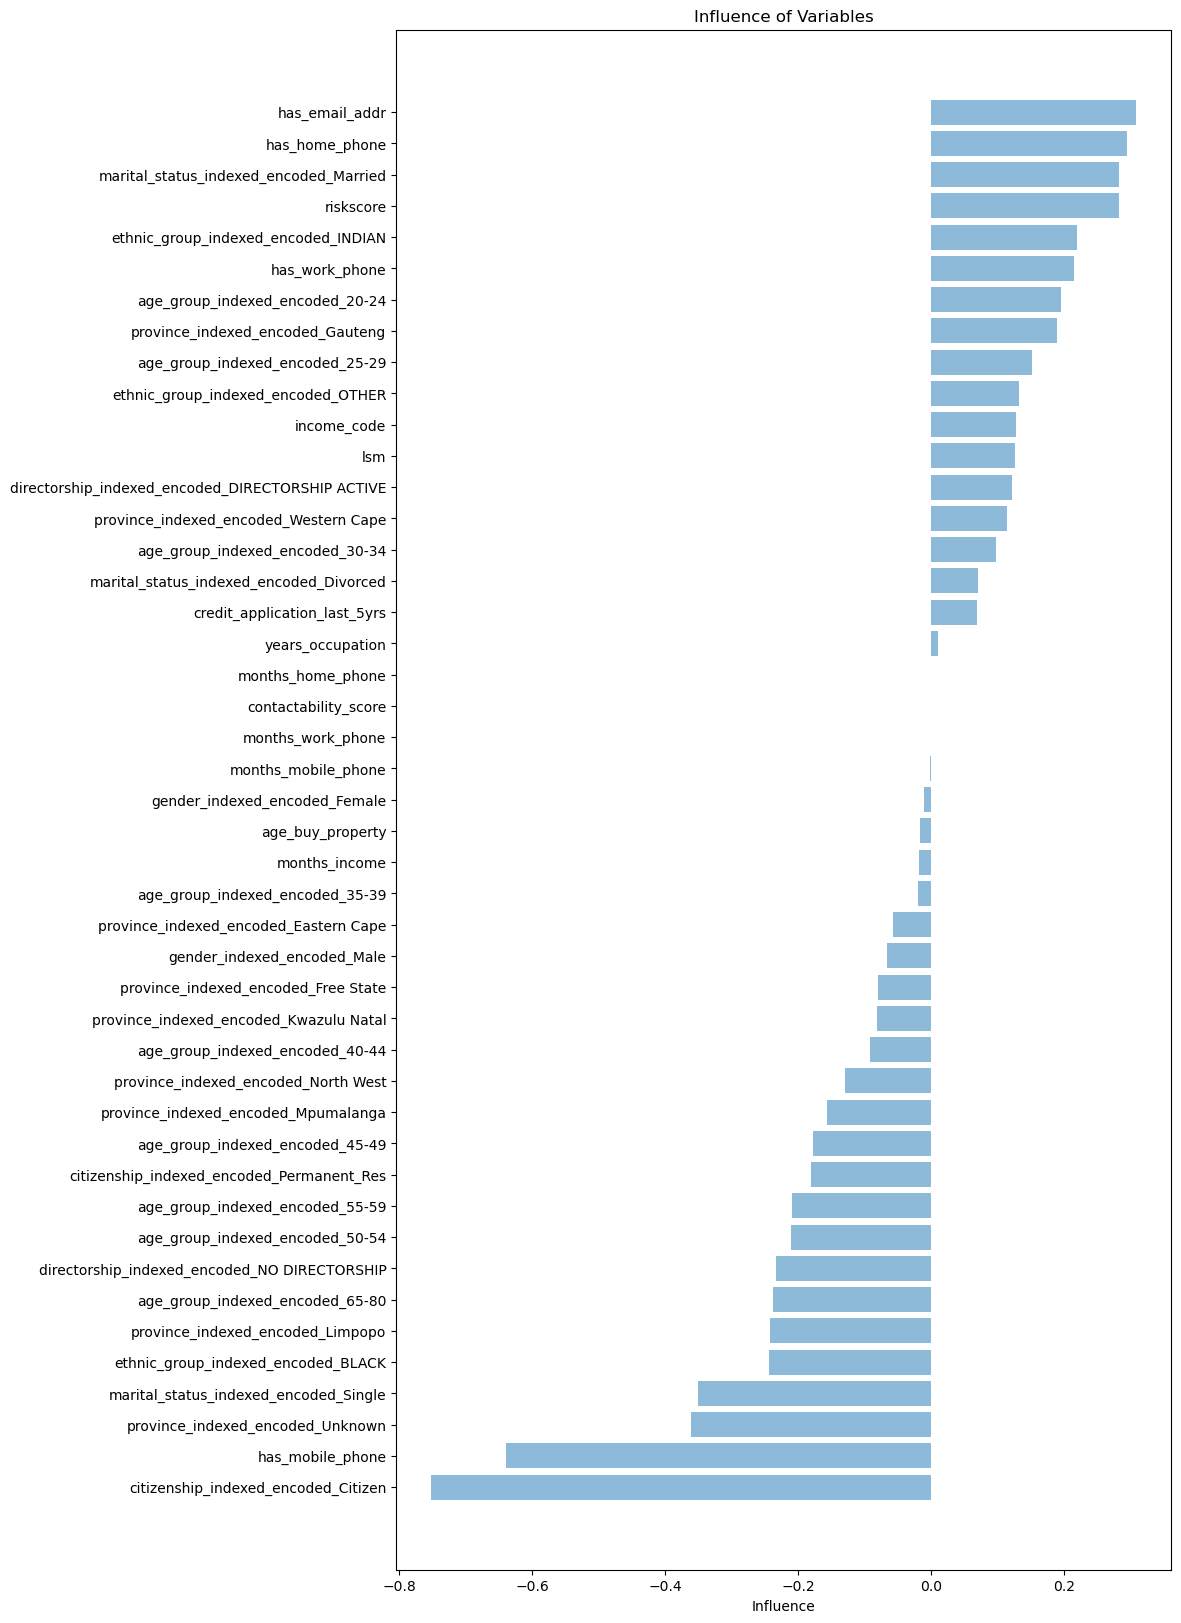

In [23]:
# plot Logistic Regression Coefficients
import numpy as np

plt.rcdefaults()


# extract all variables names after transformation
numeric_metadata = df_transformed.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
binary_metadata = df_transformed.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('binary')
features_list = numeric_metadata + binary_metadata

# Create pairs of variable names (features) and coefficients, sort by coefficient, and make two seperate lists
vars_coef = [[fature_name['name'],coef] for fature_name,coef in zip(features_list, model_lr.coefficients)]
vars_coef.sort(key=lambda l:l[1])

features = [el[0] for el in vars_coef]
coefficients = [el[1] for el in vars_coef]

plt.figure(figsize=(10,20))
y_pos = np.arange(len(features))
plt.barh(y_pos, coefficients, align='center', alpha=0.5)
plt.yticks(y_pos, features)
plt.xlabel('Influence')
plt.title('Influence of Variables')

plt.show()

As can be seen, months_home_phone, months_mobile_phone, months_work_phone, and contactability_score have close to ZERO coefficient. This means that these variables are not important in the machine learning algorithm used. So they can be removed.

### Step 2 - Revision/Re-evaluation

In [24]:
# DataFrame with reduced variables
df_red=df.drop('months_home_phone','months_mobile_phone','and months_work_phone','contactability_score')

In [25]:
# Vectorizing encoded values
numerical_columns=['age_buy_property',
 'income_code',
 'months_income',
 'riskscore',
 'has_email_addr',
 'has_mobile_phone',
 'has_home_phone',
 'has_work_phone',
 'credit_application_last_5yrs',
 'lsm',
 'years_occupation'
]

assembler = VectorAssembler(inputCols=numerical_columns+[encoder.getOutputCol() for encoder in encoders],outputCol="features")

pipeline_red = Pipeline(stages=indexers + encoders+[assembler])

# fit the transformation model
pipelineModel_red = pipeline_red.fit(df_red)

# transformed the new dataset with reduced features
df_transformed_red=pipelineModel_red.transform(df_red)

In [26]:
# split the new dataset with reduced features
df_train_red, df_test_red = train_test_split_spark(df_transformed_red, 0.8, seed=2)

             Model metrics:              
Accuracy : Train = 0.8909, Test = 0.8871
Precision: Train = 0.8911, Test = 0.8874
Recall   : Train = 0.8909, Test = 0.8871
F1 Score:  Train = 0.8909, Test = 0.8871
AUC     :  Train = 0.9538, Test = 0.9513


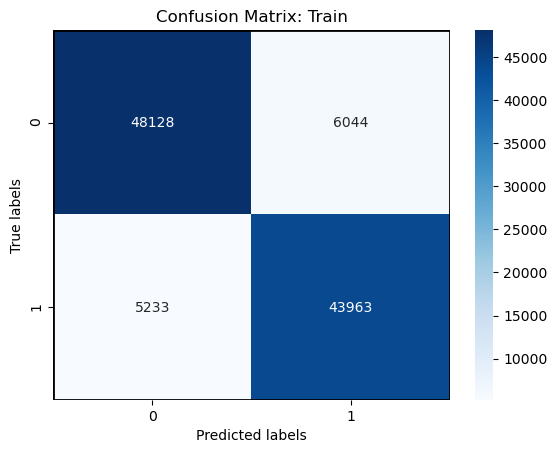

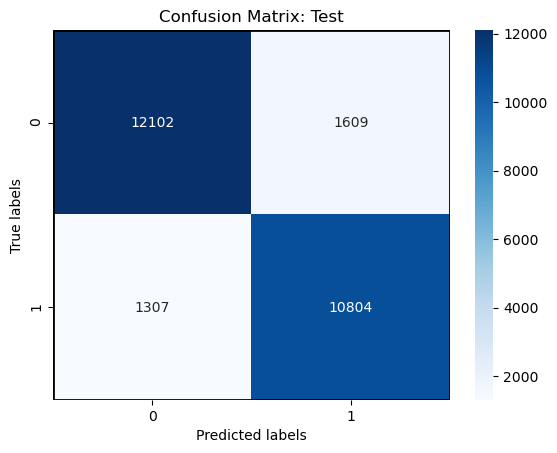

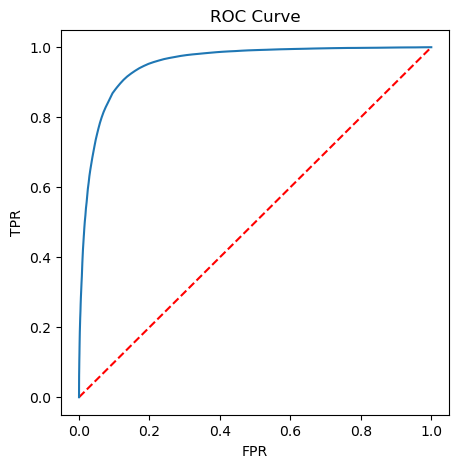

In [27]:
# train the Logistic Regression model
model_lr_red=lr.fit(df_train_red)

# evaluate the model
evaluate_model(model_lr_red, df_train_red, df_test_red)

In [28]:
row1 = df_transformed_red.select('features').collect()[0]['features']

print('Number of features used: ',row1.size)

Number of features used:  41


As can be seen, the same accuracy was achieved using 4 less features.

### Step 3 - Hyperparameter tuning by Gridsearch

In [29]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.3])
             .addGrid(lr.threshold, [0.4, 0.5, 0.6])
             .build())

In [30]:
# define the metric used for evaluation
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='buyer', metricName='accuracy')

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(df_train_red)

In [31]:
model_lr_best = cvModel.bestModel
model_lr_best.extractParamMap()

{Param(parent='LogisticRegression_f34ff83c6931', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_f34ff83c6931', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_f34ff83c6931', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_f34ff83c6931', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_f34ff83c6931', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_f34ff83c6931', name='labelCol', doc='label column name'): 'buyer',
 Param(parent='LogisticRegression_f34ff83c6931', name='maxIter', doc='maximum number of iterations (>= 0)'): 

**Best model parameters:**

regParam = 0.01

threshold = 0.5

             Model metrics:              
Accuracy : Train = 0.9002, Test = 0.8969
Precision: Train = 0.9003, Test = 0.8970
Recall   : Train = 0.9002, Test = 0.8969
F1 Score:  Train = 0.9002, Test = 0.8969
AUC     :  Train = 0.9599, Test = 0.9577


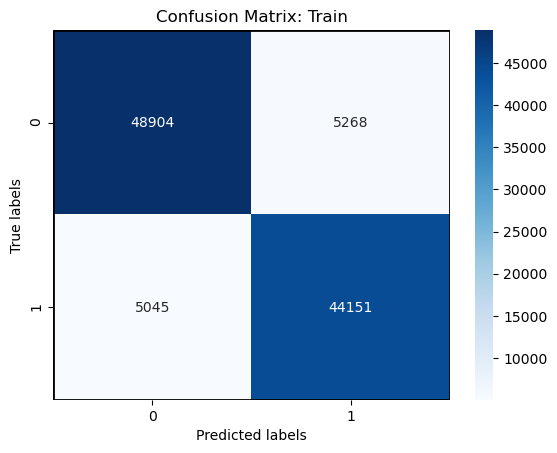

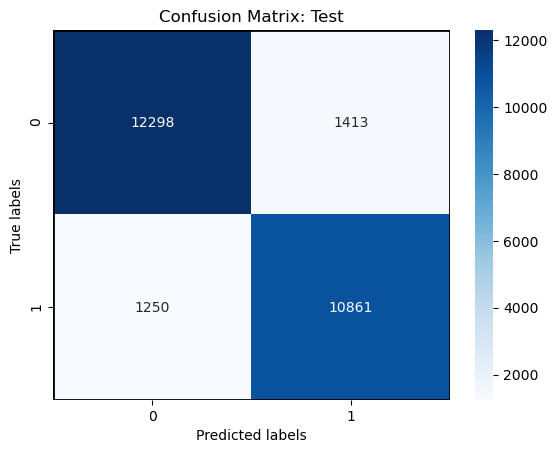

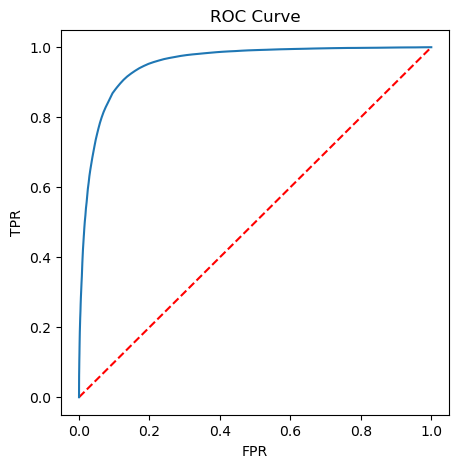

In [32]:
# evaluate the best Logistic Regression model found
evaluate_model(model_lr_best, df_train_red, df_test_red)

### Step 4 - Dimensionality reduction (PCA)

In [33]:
from pyspark.ml.feature import PCA

pca = PCA(k=10, inputCol='features',outputCol='pcaFeatures')

# define the pca model
model_pca=pca.fit(df_transformed_red)

# calculate the principle components
pcs = model_pca.transform(df_transformed_red)

In [34]:
# Pick the most importanct PCs
import numpy as np

print("Cumulative sum of explained variance:\n")
print(np.cumsum(model_pca.explainedVariance))

Cumulative sum of explained variance:

[0.71568331 0.8569408  0.92507032 0.96989682 0.9777377  0.98085641
 0.98338023 0.98554829 0.98737952 0.98903003]


In [35]:
# split the dataset
df_pc_train,df_pc_test=train_test_split_spark(pcs, 0.8, seed=2)

### Logistic Regression

             Model metrics:              
Accuracy : Train = 0.8972, Test = 0.8944
Precision: Train = 0.8972, Test = 0.8945
Recall   : Train = 0.8972, Test = 0.8944
F1 Score:  Train = 0.8972, Test = 0.8945
AUC     :  Train = 0.9555, Test = 0.9528


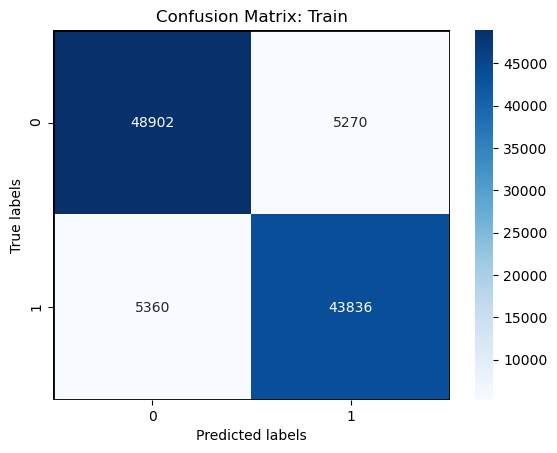

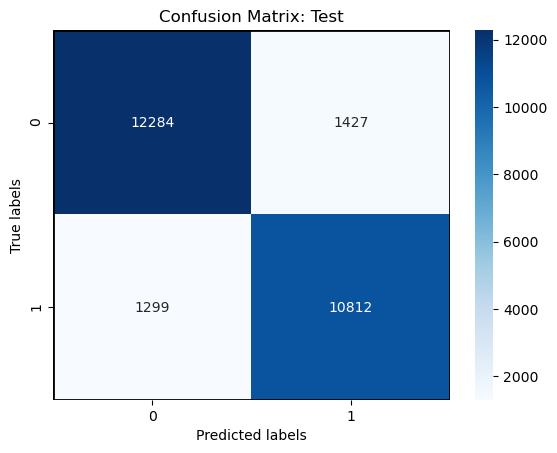

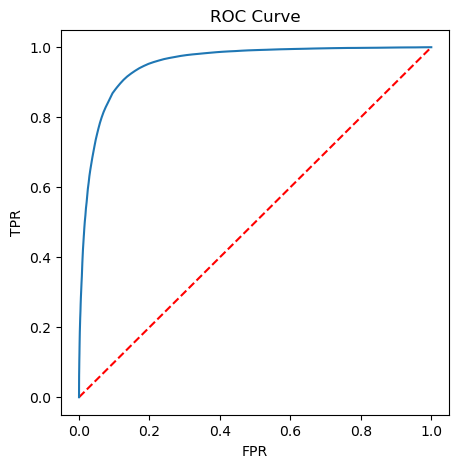

In [36]:
# Train the model using principle components

lr_pc = LogisticRegression(labelCol="buyer",
                        featuresCol="pcaFeatures",
                        maxIter=10,
                        regParam=0.01)  

# train the model
model_lr_pc=lr_pc.fit(df_pc_train)

# evaluate the model
evaluate_model(model_lr_pc,df_pc_train,df_pc_test)

As shown above, **PCA** didn't have any positive effect on the performance of the model developed. However, the training time might be decreased.

### XGBoost

             Model metrics:              
Accuracy : Train = 0.8991, Test = 0.8925
Precision: Train = 0.8992, Test = 0.8927
Recall   : Train = 0.8991, Test = 0.8925
F1 Score:  Train = 0.8991, Test = 0.8925
AUC     :  Train = 0.9629, Test = 0.9578


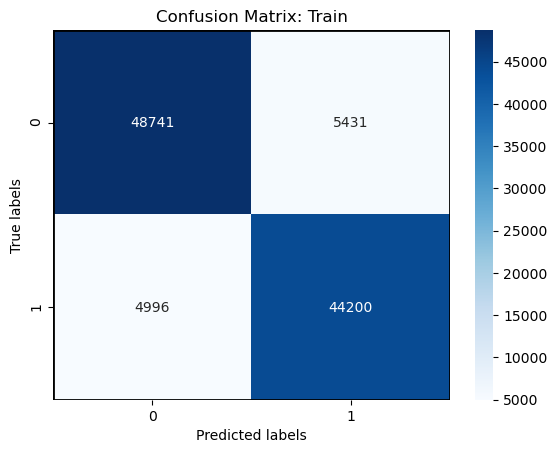

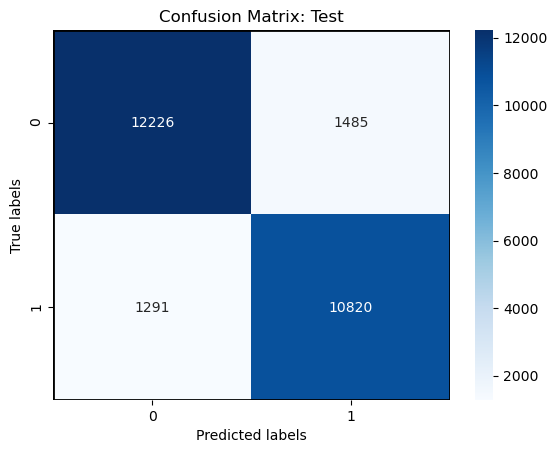

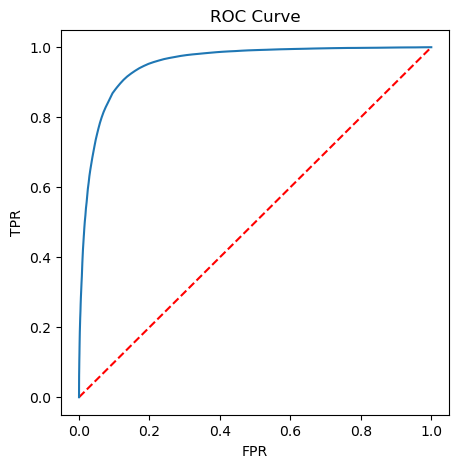

In [39]:
# change the feature column
xgb_pc = xgb.setFeaturesCol('pcaFeatures')

# train the model
model_xgb_pc=xgb_pc.fit(df_pc_train)

# evaluate the model
evaluate_model(model_xgb_pc,df_pc_train,df_pc_test)

There was no performance gain, same as Logistic Regression

# Save the model and transformation pipeline

In [43]:
# save the Logistic Regression modeln locally
model_lr_best.save('LR_Model_Final.mdl')

In [52]:
# save the transformation pipeline locally
pipelineModel_red.save("Transformation_Pipeline.ppl")

In [54]:
# The models are saved in a folder, so need to pack it to a single file

!tar cvf  LR_Model_Final.mdl.tar LR_Model_Final.mdl

!tar cvf  Transformation_Pipeline.ppl.tar Transformation_Pipeline.ppl

In [55]:
# save files in object storage

# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(spark.sparkContext, '****', '****')
pc = project.project_context


project.save_data(data="LR_Model_Final.mdl.tar",file_name='LR_Model_Final.mdl.tar',overwrite=True)

project.save_data(data="Transformation_Pipeline.ppl.tar",file_name='Transformation_Pipeline.ppl.tar',overwrite=True)